# Recherche de facteurs d'influence sur le temps de sommeil
_Darnatigues Rémy / Guiraud Philippe_

## Nous allons ici procéder à une régression linéaire multiple portant sur nos données en ne prenant que les femmes.
_Par manque de temps, les hypothèses sont simplement vérifiées mais aucune solution pour les régler n'a été réalisée. On retrouve ainsi la même présentation que le précédent notebook._

## 1] La théorie

Le modèle et nos hypothèses restent les mêmes que pour la régression initiale. Les observations ne concernant que les femmes nous gardons alors 185 lignes dans nos données.

## 2] Application

### a) Création du modèle

Voici les différentes variables qui constituent notre problème de régression linéaire : <br />

**Variable à expliquer** : le temps de sommeil que l'on note Y <br />

**Variables explicatives** : <br />
  - l'âge, noté $X_{1}$ ou age<br />
  - le temps d'activité, noté $X_{2}$ ou activ<br />
  - le battement cardiaque au repos, noté $X_{3}$ ou battement<br />
  - la pression systolique, noté $X_{4}$ ou systolique<br />
  - la pression diastolique, notée $X_{5}$ ou diastolique<br />
  - le nombre de pas quotidien, noté $X_{6}$ ou pas<br />
  - le stress, noté $X_{7}$ ou stress<br />
  
Les variables $a_{0}, a_{1}, a_{2}, a_{3}, a_{4}, a_{5}, a_{6}, a_{7}$ sont les paramètres à estimer de notre modèle.

**Notre modèle est le suivant :
$Y_{i} = a_{0} + a_{1}X_{i,1} + a_{2}X_{i,2} +a_{3}X_{i,3} + a_{4}X_{i,4} + a_{5}X_{i,5} + a_{6}X_{i,6} + a_{7}X_{i,7} +  \epsilon_{i}$**

Ci-dessous, nous récupérons les données associées à chaque variable que nous stockons dans un dataframe $X$ dont les colonnes sont nos $X_{i}$.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy.stats as stats
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from tabulate import tabulate
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from statsmodels.stats.outliers_influence import variance_inflation_factor
import statsmodels.stats.diagnostic as smd
from statsmodels.stats.diagnostic import het_breuschpagan, het_white
from scipy.stats import shapiro, normaltest
from scipy.stats import shapiro, jarque_bera
from statsmodels.graphics.tsaplots import plot_acf
from sklearn.model_selection import cross_val_score
from statsmodels.stats.diagnostic import linear_reset
from statsmodels.stats.stattools import durbin_watson
from statsmodels.stats.diagnostic import acorr_breusch_godfrey
from scipy.stats import boxcox
from IPython.display import display


fichier = pd.read_csv("Sleep_health_and_lifestyle_dataset.csv", sep=",")
fichier.drop('Person ID', axis = 1, inplace = True)
systolique = []  # valeur 1
diastolique = []  # valeur 2
for value in fichier["Blood Pressure"]:
    val_1, val_2 = value.split('/')
    systolique.append(int(val_1))  
    diastolique.append(int(val_2)) 
fichier['Systolic'] = systolique
fichier['Diastolic'] = diastolique
fichier.drop('Blood Pressure', axis = 1, inplace = True)
fichier["Sleep Disorder"] = fichier["Sleep Disorder"].fillna("Aucun")
fichier["BMI Category"] = fichier["BMI Category"].replace({"Normal Weight": "Normal"})
indice_hommes = np.where(fichier["Gender"] == "Female")
Y = fichier.iloc[indice_hommes]["Sleep Duration"]
age = fichier.iloc[indice_hommes]["Age"]
activ = fichier.iloc[indice_hommes]["Physical Activity Level"]
battement = fichier.iloc[indice_hommes]["Heart Rate"]
pas = fichier.iloc[indice_hommes]["Daily Steps"]
stress = fichier.iloc[indice_hommes]["Stress Level"]
systolique = fichier.iloc[indice_hommes]["Systolic"]
diastolique = fichier.iloc[indice_hommes]["Diastolic"]

X_unscaled = pd.DataFrame(np.column_stack([Y, age, activ, battement, systolique, diastolique, pas, stress]),
                 columns=['Y', 'age', 'activ', 'bpm', 'syst', 'diast', 'pas', 'stress'])

### b) Normalisation des données

Nous normalisons les données pour éviter l'influence des différentes échelles des variables sur notre analyse.

In [2]:
# Séparer la variable cible 'Y' des variables explicatives
Y = X_unscaled['Y'].values  # Extraire Y sous forme de tableau NumPy
X_features = X_unscaled.drop(columns=['Y'])  # Conserver seulement les variables explicatives

# Appliquer la normalisation 
scaler = MinMaxScaler()
X_standardized = scaler.fit_transform(X_features)  # Transforme les données

# Convertir en DataFrame avec les mêmes noms de colonnes
X = pd.DataFrame(X_standardized, columns=X_features.columns)

# Vérification : Moyenne ~ 0 et Écart-Type ~ 1
print("Moyennes après normalisation :", X.mean().round(4))
print("Écarts-types après normalisation :", X.std().round(4))

# Réintégrer Y si besoin
X.insert(0, 'Y', Y)

Moyennes après normalisation : age       0.6135
activ     0.4857
bpm       0.2242
syst      0.6080
diast     0.5659
pas       0.5284
stress    0.3351
dtype: float64
Écarts-types après normalisation : age       0.2698
activ     0.3503
bpm       0.2332
syst      0.3791
diast     0.3940
pas       0.2587
stress    0.3824
dtype: float64


Une fois les données normalisées, nous vérifions nos hypothèses de départ.

### c) Vérification des hypothèses de départ

##### Hypothèse 1 : Toutes les corrélations ne doivent pas être nulles.  

Pour la vérifier on rappelle la matrice de corrélation de notre modèle.

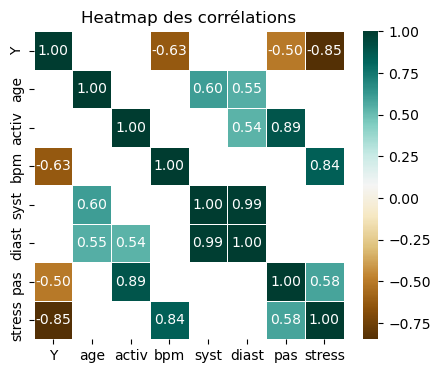

In [3]:
plt.figure(figsize=(5, 4))  # Taille du graphique
sns.heatmap(X.corr()[X.corr().abs() > 0.5], annot=True, cmap="BrBG", fmt=".2f", linewidths=0.5)

plt.title("Heatmap des corrélations")
plt.show()

**L'hypothèse 1 est validée.**

##### Hypothèse 2 : Les $X_{i}$ ne sont pas colinéaires, *i.e.* pas de multicolinéarité entre variables.

De la matrice de corrélation ci-dessus, les seules valeurs égales à 1 sont les coefficients diagonaux.  
On remarque cependant une corrélation très forte entre les pressions systolique et diastolique.  
On réalise alors deux tests : le test du VIF et le test condition number avec H0 : il n'y a pas de multicolinéarité entre variables.  

In [4]:
# Multicolinéarité
X = X.drop(columns=['Y'])
X = sm.add_constant(X)
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)
print("VIF (Variance Inflation Factor) :")

# Test de Multicolinéarité
high_vif = vif_data[vif_data["VIF"] > 10]
if not high_vif.empty:
    print("Test de Multicolinéarité (VIF) : Il y a une multicolinéarité excessive entre certaines variables (rejette H0).")
else:
    print("Test de Multicolinéarité (VIF) : Il n'y a pas de multicolinéarité excessive (ne rejette pas H0).")

  feature         VIF
0   const   23.608237
1     age    5.040922
2   activ   36.415135
3     bpm   14.193958
4    syst  255.571521
5   diast  257.954077
6     pas   27.179393
7  stress   19.212166
VIF (Variance Inflation Factor) :
Test de Multicolinéarité (VIF) : Il y a une multicolinéarité excessive entre certaines variables (rejette H0).


**L'hypothèse 2 est rejetée**  
Les tests rejettent la non-colinéarité, on remarque que ce résultat est dû à une colinéarité forte entre les pressions systolique et diastolique.  
Nous prenons la décision d'enlever la variable diastolique de notre modèle puisque c'est celle ayant le VIF le plus élevé. Nous réalisons de nouveau le test VIF, et ajoutons à celui-ci le test du Condition Number pour tester s'il y a une combinaison linéaire de variable avec une forte multicolinéarité.

In [5]:
X_syst = X.drop(columns=['diast'])

In [6]:
vif_data = pd.DataFrame()
vif_data["feature"] = X_syst.columns
vif_data["VIF"] = [variance_inflation_factor(X_syst.values, i) for i in range(X_syst.shape[1])]
print(vif_data)
print("VIF (Variance Inflation Factor) :")

# Test de Multicolinéarité
high_vif = vif_data.loc[vif_data.index[1:]]
high_vif = high_vif[high_vif["VIF"] > 10]
if not high_vif.empty:
    print("Test de Multicolinéarité (VIF) : Il y a une multicolinéarité excessive entre certaines variables (rejette H0).")
else:
    print("Test de Multicolinéarité (VIF) : Il n'y a pas de multicolinéarité excessive (ne rejette pas H0).")

# Test Condition Number

condition_number = np.linalg.cond(X_syst)
print(f'Condition Number: {condition_number}')
if condition_number > 30:
    print("Test de Multicolinéarité (Condition Number) : Il y a une multicolinéarité excessive (rejette H0).")
else:
    print("Test de Multicolinéarité (Condition Number) : Il n'y a pas de multicolinéarité excessive (ne rejette pas H0).")

  feature        VIF
0   const  23.556702
1     age   2.758222
2   activ  21.241421
3     bpm  12.359502
4    syst   3.624295
5     pas  24.633093
6  stress  18.966141
VIF (Variance Inflation Factor) :
Test de Multicolinéarité (VIF) : Il y a une multicolinéarité excessive entre certaines variables (rejette H0).
Condition Number: 47.053777475013696
Test de Multicolinéarité (Condition Number) : Il y a une multicolinéarité excessive (rejette H0).


Les tests VIF et Condition Number confirment la présence d'une multicolinéarité excessive. Comme nous voulons garder un certain nombre de variables explicatives, nous avons fait le choix de conserver les 6 variables présentes ci-dessus.  
**L'hypothèse 1 n'est pas validée.**

***Une fois les hypothèses de départ vérifiées nous pouvons réaliser une régression linéaire multiple sur le modèle retenu.***

## 3] Régression linéaire multiple

#### Réalisons une régression multiple sur notre modèle en prenant en compte toutes les variables quantitatives explicatives, excepté la pression systolique, et tous les individus.

On introduit le code de la régression multiple, qui nous fournira la matrice des coefficients ainsi que le R2.

In [7]:
def regression_multiple(*vars_exp, Y):
    # Conversion des listes en tableau NumPy
    X = np.column_stack(vars_exp)  # Regroupe les variables explicatives en colonnes
    Y = np.array(Y)  # Conversion de Y en array

    n, p = X.shape  # Nombre d'observations et nombre de variables explicatives

    # Ajout de la colonne de 1 pour l'ordonnée à l'origine (β0)
    X_b = np.c_[np.ones(n), X]

    # Estimation des coefficients avec la formule des moindres carrés : β = (X'X)^-1 X'Y
    theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

    # Prédictions du modèle
    Y_pred = X_b.dot(theta)

    # Calcul du R² : 1 - (SCE / SCT)
    SCE = np.sum((Y - Y_pred) ** 2)  # Somme des carrés des erreurs
    SCT = np.sum((Y - np.mean(Y)) ** 2)  # Somme totale des carrés
    R2 = 1 - (SCE / SCT)

    # **Calcul du R² ajusté**
    R2_adj = 1 - ((1 - R2) * (n - 1) / (n - p - 1))

    # **Calcul des erreurs standards des coefficients**
    sigma2 = SCE / (n - p - 1)  # Variance des résidus
    var_theta = sigma2 * np.linalg.inv(X_b.T.dot(X_b))  # Matrice de variance-covariance
    se_theta = np.sqrt(np.diag(var_theta))  # Erreur standard de chaque coefficient

    # **Test de Student pour chaque coefficient**
    t_stats = theta / se_theta  # Statistique t
    p_values = 2 * (1 - stats.t.cdf(np.abs(t_stats), df=n - p - 1))  # p-valeurs bilatérales

    # **Test de Fisher pour l'ensemble du modèle**
    MSR = (SCT - SCE) / p  # Moyenne des carrés de la régression
    MSE = SCE / (n - p - 1)  # Moyenne des carrés des erreurs
    F_stat = MSR / MSE  # Statistique F
    p_value_F = 1 - stats.f.cdf(F_stat, dfn=p, dfd=n - p - 1)  # p-valeur associée

    return theta, R2, R2_adj, t_stats, p_values, F_stat, p_value_F

In [8]:
theta1, R2_1, R2_aj1, t_stats1, p_values1, F_stat1, p_value_F1 = regression_multiple(X['age'], X['activ'], X['bpm'], X['diast'], X['pas'], X['stress'], Y=Y)

print("Coefficients:", theta1)
print("R²:", R2_1)
print("R2 ajusté :", R2_aj1)
print("Statistiques t:", t_stats1)
print("p-valeurs:", p_values1)
print("Statistique F:", F_stat1)
print("p-valeur du test F:", p_value_F1)

Coefficients: [ 6.8902498   2.00893728 -0.29614286  1.89652729 -0.93553593  0.18923418
 -2.22269806]
R²: 0.9295812981613905
R2 ajusté : 0.927207634054471
Statistiques t: [ 81.55269146  20.30346574  -1.2184592    7.06563485 -11.01909682
   0.55333884 -11.09495904]
p-valeurs: [0.00000000e+00 0.00000000e+00 2.24661991e-01 3.48214790e-11
 0.00000000e+00 5.80725749e-01 0.00000000e+00]
Statistique F: 391.6229324324303
p-valeur du test F: 1.1102230246251565e-16


#### 1) Linéarite 

On affiche le graphique des résidus et des valeurs ajustées pour voir si une tendance se dessine pour invalider l'hypothèse, et on réalise aussi le test de Ramsey-RESET.

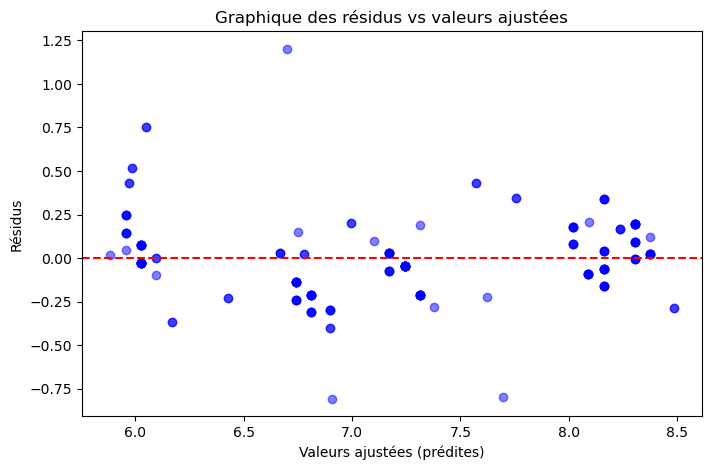

In [9]:
#   Régression linéaire
model = sm.OLS(Y, X_syst).fit()
Y_pred = model.predict(X_syst)

#   Calcul des résidus
residuals = Y - Y_pred

#   Affichage du scatterplot des résidus
plt.figure(figsize=(8, 5))
plt.scatter(Y_pred, residuals, alpha=0.5, color="blue")
plt.axhline(y=0, color="red", linestyle="--")  # Ligne de référence à 0
plt.xlabel("Valeurs ajustées (prédites)")
plt.ylabel("Résidus")
plt.title("Graphique des résidus vs valeurs ajustées")
plt.show()

In [10]:
#   Test de Ramsey RESET
reset_test = linear_reset(model, power=2, test_type='fitted')

#   Affichage des résultats
print("Résultat du test de Ramsey RESET :")
print(reset_test)

#   Interprétation du test
alpha = 0.05  # Seuil de significativité (5%)
p_value = reset_test.pvalue  # Récupération de la p-value

if p_value > alpha:
    print("✅ L'hypothèse de linéarité est validée (p-value =", round(p_value, 4), ")")
else:
    print("❌ L'hypothèse de linéarité est rejetée (p-value =", round(p_value, 4), ")")

Résultat du test de Ramsey RESET :
<Wald test (chi2): statistic=106.57530095410618, p-value=5.515636784026481e-25, df_denom=1>
❌ L'hypothèse de linéarité est rejetée (p-value = 0.0 )


#### 2) Significativité des coefficients

On réalise le test de Student sur les coefficients et le test de Fisher sur le modèle global pour vérifier la significativité des coefficients.

In [11]:
# Exécution de la régression multiple avec les noms des variables
var_names = ["age", "activ", "battement", "diastolique", "pas", "stress"]
theta1, R2_1, R2_aj1, t_stats1, p_values1, F_stat1, p_value_F1 = regression_multiple(X['age'], X['activ'], X['bpm'], X['diast'], X['pas'], X['stress'], Y=Y)

# **Affichage des résultats**
print("=== Résultats de la régression linéaire multiple ===")
print(f"R² du modèle : {R2_1:.4f}\n")

print("--- Test de Student (t-test) ---")
print(f"Intercept : t = {t_stats1[0]:.4f}, p-value = {p_values1[0]:.4f} {'*' if p_values1[0] < 0.05 else ''}")
for i, (name, t, p) in enumerate(zip(var_names, t_stats1[1:], p_values1[1:]), start=1):
    print(f"{name} : t = {t:.4f}, p-value = {p:.4f} {'*' if p < 0.05 else ''}")

print("\n--- Test de Fisher (F-test) ---")
print(f"Statistique F = {F_stat1:.4f}, p-value = {p_value_F1:.4f}")

# **Interprétation rapide**
if p_value_F1 < 0.05:
    print("Le modèle global est statistiquement significatif.")
else:
    print("Le modèle global n'est PAS statistiquement significatif.")

# Vérification des coefficients significatifs
significatifs = [name for name, p in zip(var_names, p_values1[1:]) if p < 0.05]
if significatifs:
    print(f"Les variables significatives sont : {', '.join(significatifs)}")
else:
    print("Aucune variable explicative n'est significative au seuil de 5%.")


=== Résultats de la régression linéaire multiple ===
R² du modèle : 0.9296

--- Test de Student (t-test) ---
Intercept : t = 81.5527, p-value = 0.0000 *
age : t = 20.3035, p-value = 0.0000 *
activ : t = -1.2185, p-value = 0.2247 
battement : t = 7.0656, p-value = 0.0000 *
diastolique : t = -11.0191, p-value = 0.0000 *
pas : t = 0.5533, p-value = 0.5807 
stress : t = -11.0950, p-value = 0.0000 *

--- Test de Fisher (F-test) ---
Statistique F = 391.6229, p-value = 0.0000
Le modèle global est statistiquement significatif.
Les variables significatives sont : age, battement, diastolique, stress


#### 3) Moyenne des résidus nulle 

On affiche l'histogramme des résidus et on réalise un test de Student sur les résidus.

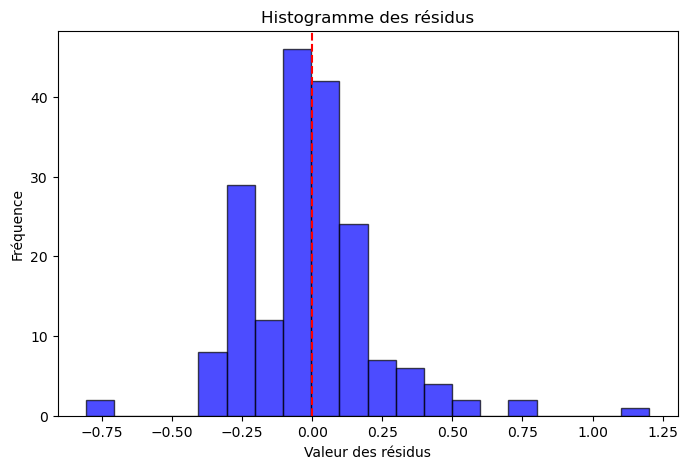

In [12]:
# 📊 Affichage de l'histogramme des résidus
plt.figure(figsize=(8, 5))
plt.hist(residuals, bins=20, edgecolor="black", alpha=0.7, color="blue")
plt.axvline(x=0, color="red", linestyle="--")  # Ligne verticale à 0
plt.xlabel("Valeur des résidus")
plt.ylabel("Fréquence")
plt.title("Histogramme des résidus")
plt.show()

In [13]:
#   Test de Student (H0 : moyenne des résidus = 0)
t_stat, p_value = stats.ttest_1samp(residuals, 0)

#   Affichage des résultats
print(f"Statistique de test t : {t_stat:.4f}")
print(f"p-value : {p_value:.4f}")


if p_value > alpha:
    print("\n✅ L'hypothèse d'une moyenne des résidus nulle est validée (p-value =", round(p_value, 4), ")")
else:
    print("\n❌ L'hypothèse est rejetée : la moyenne des résidus est significativement différente de 0 (p-value =", round(p_value, 4), ")")
    print("👉 Il peut y avoir un biais dans le modèle.")


Statistique de test t : 0.0000
p-value : 1.0000

✅ L'hypothèse d'une moyenne des résidus nulle est validée (p-value = 1.0 )


C'est un résultat auquel on s'attendait car on a ajouté une constante au modèle.

#### 4) Non corrélation des résidus

Il n'y a pas de temporalité ni de données ordonnées dans notre modèle, cette vérification n'est donc pas nécessaire.

#### 5) Homoscédasticité 

On réalise les tests de Breusch-Pagan et de White, ainsi qu'un diagramme des résidus et des valeurs ajustées pour observer l'homoscédasticité du modèle.

In [14]:
X_features = X_syst

X_b = sm.add_constant(X_syst)
    
# Ajustement du modèle de régression
model = sm.OLS(Y, X_b).fit()

# Extraction des résidus
residuals = model.resid

# Test de Breusch-Pagan
bp_test = smd.het_breuschpagan(residuals, X_b)
bp_stat, bp_pvalue = bp_test[0], bp_test[1]  # Statistique du test et p-value

# Test de White
white_test = smd.het_white(residuals, X_b)
white_stat, white_pvalue = white_test[0], white_test[1]  # Statistique du test et p-value

# Affichage des résultats
print("\n=== Test de Breusch-Pagan ===")
print(f"Statistique : {bp_stat:.4f}, p-value : {bp_pvalue:.4f}")
if bp_pvalue < 0.05:
    print("⚠️ Hétéroscédasticité détectée (rejette H0)")
else:
    print("✅ Homoscédasticité confirmée (on ne rejette pas H0)")

print("\n=== Test de White ===")
print(f"Statistique : {white_stat:.4f}, p-value : {white_pvalue:.4f}")
if white_pvalue < 0.05:
    print("⚠️ Hétéroscédasticité détectée (rejette H0)")
else:
    print("✅ Homoscédasticité confirmée (on ne rejette pas H0)")


=== Test de Breusch-Pagan ===
Statistique : 34.2242, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)

=== Test de White ===
Statistique : 182.2062, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)


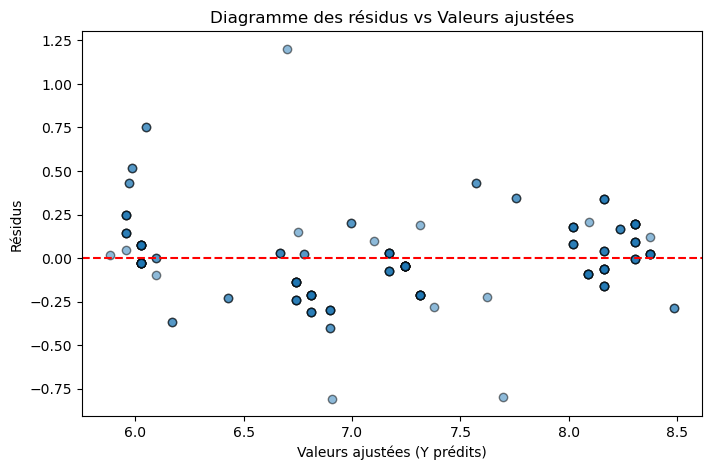

In [15]:
# 🔹 Affichage du diagramme des résidus vs valeurs ajustées
fitted_values = Y-residuals
plt.figure(figsize=(8, 5))
plt.scatter(fitted_values, residuals, alpha=0.5, edgecolors='black')
plt.axhline(y=0, color='red', linestyle='dashed')  # Ligne horizontale à zéro

plt.xlabel("Valeurs ajustées (Y prédits)")
plt.ylabel("Résidus")
plt.title("Diagramme des résidus vs Valeurs ajustées")
plt.show()

On va donc s'occuper de l'hétéroscédasticité et tester plusieurs modifications du modèle, à savoir :  
Modèle 1 : On applique le log à Y  
Modèle 2 : On applique la racine à carrée à Y  
Modèle 3 : On applique le boxcox à Y  
Modèle 4 : On utilise le WLS sur les résidus  
Modèle 5 : On change le modèle en GLS  
Modèle 6 : On change le modèle avec une régression quantile  
Modèle 7 : On change le modèle avec un modèle robuste  

In [16]:
liste_model = []
model_Ylog = sm.OLS(np.log(Y), X_b).fit()
liste_model.append(model_Ylog)
model_Ysqrt = sm.OLS(np.sqrt(Y), X_b).fit()
liste_model.append(model_Ysqrt)
Y_transformed, lambda_bc = boxcox(Y + 1e-6)
poids = 1 / (residuals**2 + 1e-6)
model_WLS = sm.WLS(Y, X_b, weights = poids).fit()
liste_model.append(model_WLS)
model_Yboxcox = sm.OLS(Y_transformed, X_b).fit()
liste_model.append(model_Yboxcox)
model_GLS = sm.GLS(Y, X_b).fit()
liste_model.append(model_GLS)
model_quantile = sm.QuantReg(Y, X_b).fit(q=0.5)
liste_model.append(model_GLS)
model_robuste = sm.OLS(Y, X_b).fit(cov_type='HC3')
liste_model.append(model_robuste)

In [17]:
model_resid = []
for i in range(len(liste_model)):
    model_resid.append(liste_model[i].resid)

On réapplique les tests de Breusch-Pagan et White pour chacun des nouveaux modèles à tester :  

In [18]:
for i in range(len(liste_model)):
    print("Pour le modèle", i+1, "voici les résultats des tests :")
# Test de Breusch-Pagan
    bp_test = smd.het_breuschpagan(model_resid[i], X_b)
    bp_stat, bp_pvalue = bp_test[0], bp_test[1]  # Statistique du test et p-value

# Test de White
    white_test = smd.het_white(model_resid[i], X_b)
    white_stat, white_pvalue = white_test[0], white_test[1]  # Statistique du test et p-value

# Affichage des résultats
    print("\n=== Test de Breusch-Pagan ===")
    print(f"Statistique : {bp_stat:.4f}, p-value : {bp_pvalue:.4f}")
    if bp_pvalue < 0.05:
        print("⚠️ Hétéroscédasticité détectée (rejette H0)")
    else:
        print("✅ Homoscédasticité confirmée (on ne rejette pas H0)")

    print("=== Test de White ===")
    print(f"Statistique : {white_stat:.4f}, p-value : {white_pvalue:.4f}")
    if white_pvalue < 0.05:
        print("⚠️ Hétéroscédasticité détectée (rejette H0)\n")
    else:
        print("✅ Homoscédasticité confirmée (on ne rejette pas H0)\n")

Pour le modèle 1 voici les résultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 33.3459, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)
=== Test de White ===
Statistique : 182.1564, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)

Pour le modèle 2 voici les résultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 33.7254, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)
=== Test de White ===
Statistique : 182.1838, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)

Pour le modèle 3 voici les résultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 31.6798, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)
=== Test de White ===
Statistique : 182.7140, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)

Pour le modèle 4 voici les résultats des tests :

=== Test de Breusch-Pagan ===
Statistique : 33.4897, p-value : 0.0000
⚠️ Hétéroscédasticité détectée (rejette H0)
=== Test de White ==

On affiche aussi le diagramme des résidus comparé aux valeurs ajustées pour chaque modèle (rien ne change si ce n'est l'échelle).

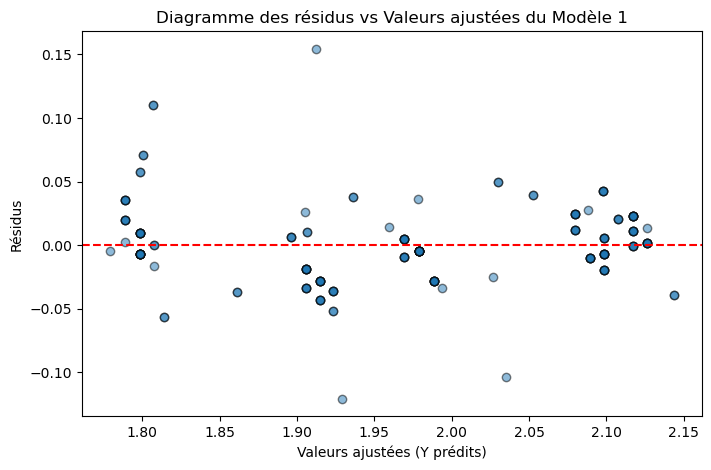

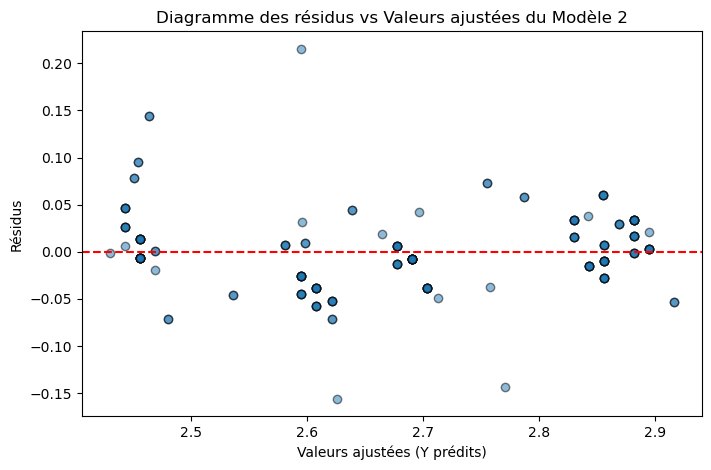

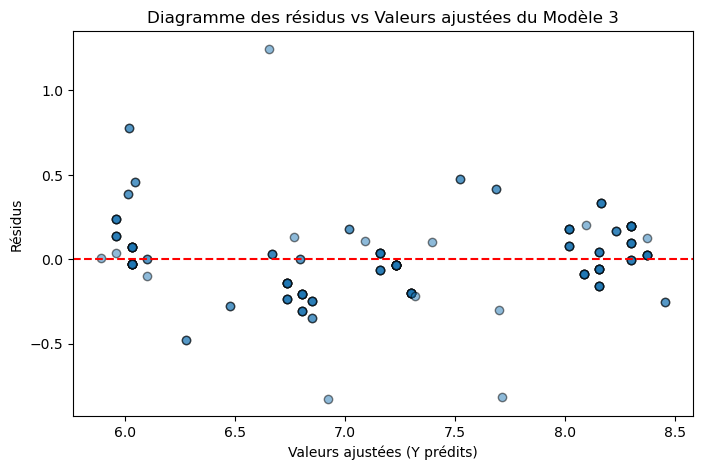

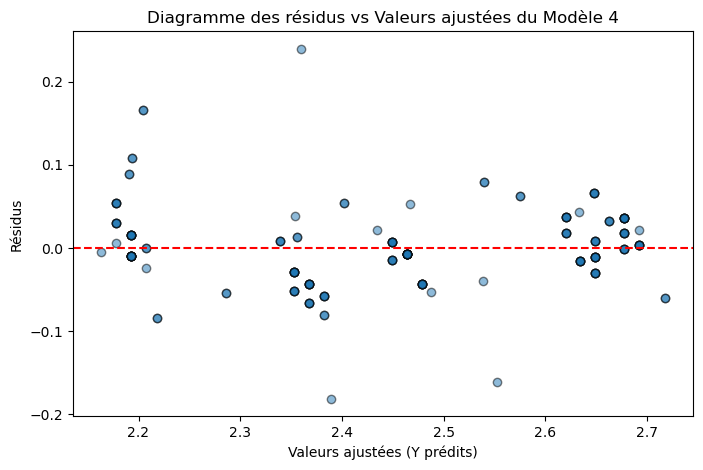

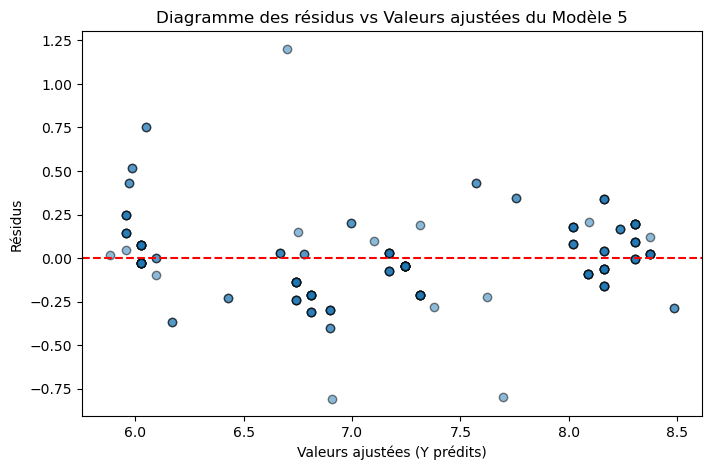

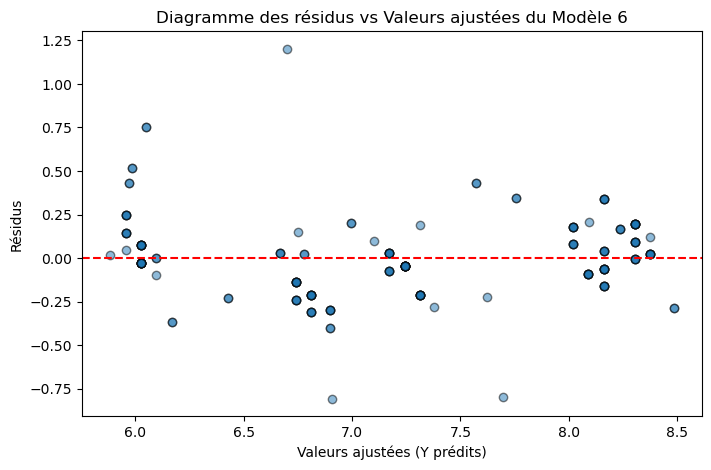

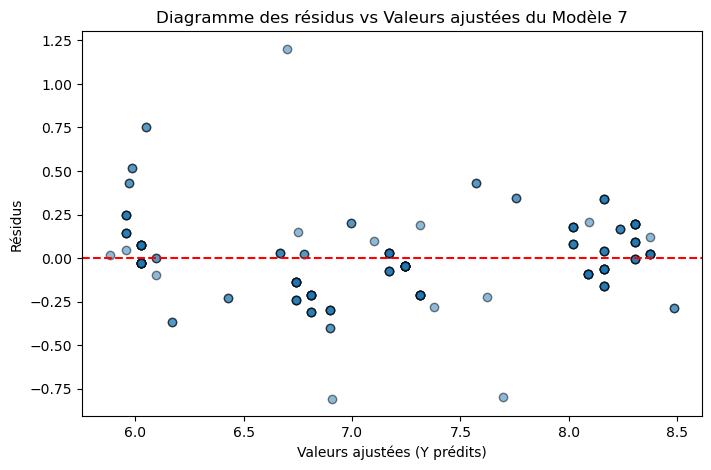

In [19]:
# 🔹 Affichage du diagramme des résidus vs valeurs ajustées
for i in range(len(liste_model)):
    plt.figure(figsize=(8, 5))
    plt.scatter(liste_model[i].fittedvalues, model_resid[i], alpha=0.5, edgecolors='black')
    plt.axhline(y=0, color='red', linestyle='dashed')  # Ligne horizontale à zéro

    plt.xlabel("Valeurs ajustées (Y prédits)")
    plt.ylabel("Résidus")
    plt.title(f"Diagramme des résidus vs Valeurs ajustées du Modèle {i+1}")
    plt.show()

On s'aperçoit que notre hétéroscédasticité est toujours présente malgré les nombreux essais de changement du modèle.  
**On ne valide donc pas l'hypothèse de l'hétéroscédasticité du modèle.**

#### 6) Normalité des résidus 

On affiche l'histogramme et le QQPlotdes résidus, et on réalise les tests de Shapiro-Wilk et Jarque-Bera afin de tester la normalité des résidus.

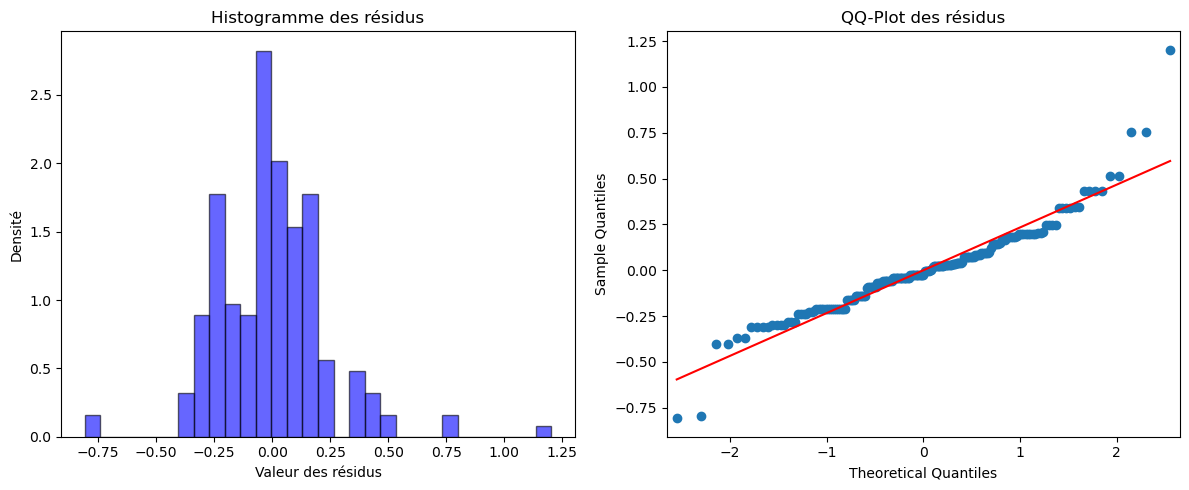

In [20]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(residuals, bins=30, density=True, alpha=0.6, color='b', edgecolor='black')
plt.title("Histogramme des résidus")
plt.xlabel("Valeur des résidus")
plt.ylabel("Densité")

# QQ-Plot
plt.subplot(1, 2, 2)
sm.qqplot(residuals, line='s', ax=plt.gca())
plt.title("QQ-Plot des résidus")

plt.tight_layout()
plt.show()

In [21]:
#   Test de Shapiro-Wilk
shapiro_test = shapiro(residuals)
print(f"Shapiro-Wilk Test : Statistique = {shapiro_test.statistic:.4f}, p-value = {shapiro_test.pvalue:.4f}")

#   Test de Jarque-Bera
jarque_bera_test = jarque_bera(residuals)
print(f"Jarque-Bera Test : Statistique = {jarque_bera_test.statistic:.4f}, p-value = {jarque_bera_test.pvalue:.4f}")

# ✅ Interprétation
alpha = 0.05  # Seuil de signification
if shapiro_test.pvalue > alpha and jarque_bera_test.pvalue > alpha:
    print("✅ Les résidus suivent une distribution normale (on ne rejette pas H0).")
else:
    print("❌ Les résidus ne suivent PAS une distribution normale (on rejette H0).")

Shapiro-Wilk Test : Statistique = 0.9299, p-value = 0.0000
Jarque-Bera Test : Statistique = 182.5160, p-value = 0.0000
❌ Les résidus ne suivent PAS une distribution normale (on rejette H0).


On a essayé de réaliser un bootstrap pour nous occuper de la distribution non-normale de nos résidus, mais nous n'avons pas réussi à produire un résultat probant.

#### 7) Calcul AIC / BIC

On calcule les critères AIC et BIC de notre modèle.

In [22]:
n = X.shape[0]  # Nombre d'observations

# Ajout de la colonne de 1 pour l'intercept (β0)
X_b = np.c_[np.ones(n), X]

# Calcul de theta avec la formule des MCO
theta1 = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(Y)

n, p = X.shape  # Nombre d'observations et de variables explicatives

# Ajout de la constante (colonne de 1)
X_b = np.c_[np.ones(n), X]

# Prédictions
Y_pred = X_b.dot(theta1)

# Erreurs résiduelles
residuals = Y - Y_pred

# SSE (Somme des carrés des erreurs)
SSE = np.sum(residuals ** 2)

# Calcul des critères
AIC = n * np.log(SSE / n) + 2 * (p + 1)
BIC = n * np.log(SSE / n) + (p + 1) * np.log(n)

print("Critère AIC :", AIC)
print("Critère AIC :", BIC)

Critère AIC : 3153.0411056244284
Critère AIC : 3182.024308050133


#### Tableau récapitulatif des étapes réalisées :

In [25]:
# Définition des données sous forme de dictionnaire
data = {
    "Hypothèse": [
        "Linéarité",
        "Significativité des coefficients",
        "Moyenne des résidus nulle",
        "Non-corrélation des résidus",
        "Homoscédasticité",
        "Normalité des résidus"
    ],
    "Validation graphique": [
        "Scatterplot des résidus : On semble valider l'hypothèse.",
        "-",
        "Histogramme des résidus : On semble valider l'hypothèse.",
        "-",
        "Diagramme des résidus et valeurs ajustées : On semble valider visuellement l'absence d'hétéroscédasticité (pas de cône).",
        "Histogramme et QQ-plot des résidus : On ne valide pas l'hypothèse (problèmes à gauche de l'histogramme et du QQplot)."
    ],
    "Validation avec Test": [
        f"Test de Ramsey RESET (p-value > 0.05) : {round(reset_test.pvalue, 3)}. On ne valide pas l'hypothèse",
        f"Test de Fisher (p-value < 0.05): {round(p_value_F1, 3)}. Le modèle est statistiquement significatif.",
        f"Test de Student (p-value > 0.05): {p_value:.3f}. On valide l'hypothèse.",
        "-",
        f"Test de Breusch-Pagan (p-value > 0.05) : {bp_pvalue:.3f}. Test de White (p-value > 0.05): {white_pvalue:.3f}. On rejette l'hypothèse pour les deux tests.",
        f"Test de Shapiro-Wilk (p-value > 0.05) : {shapiro_test.pvalue:.3f}. Test de Jarque-Bera (p-value > 0.05) : {jarque_bera_test.pvalue:.3f}. On rejette l'hypothèse pour les deux tests."
    ],
    "Validation de l'hypothèse": [
        "Hypothèse non validée",
        "Hypothèse validée",
        "Hypothèse validée",
        "Non traité, absence de temporalité",
        "Hypothèse non validée",
        "Hypothèse non validée"
    ]
}

# Création du DataFrame
df = pd.DataFrame(data)
pd.set_option('display.max_colwidth', None)  # Ajuste la largeur des colonnes
pd.set_option('display.expand_frame_repr', True)  # Empêche le retour à la ligne
pd.set_option('display.colheader_justify', 'left')  # Justifie le texte à gauche
# Affichage du tableau
display(df)


,Hypothèse,Validation graphique,Validation avec Test,Validation de l'hypothèse
0,Linéarité,Scatterplot des résidus : On semble valider l'hypothèse.,Test de Ramsey RESET (p-value > 0.05) : 0.0. On ne valide pas l'hypothèse,Hypothèse non validée
1,Significativité des coefficients,-,Test de Fisher (p-value < 0.05): 0.0. Le modèle est statistiquement significatif.,Hypothèse validée
2,Moyenne des résidus nulle,Histogramme des résidus : On semble valider l'hypothèse.,Test de Student (p-value > 0.05): 1.000. On valide l'hypothèse.,Hypothèse validée
3,Non-corrélation des résidus,-,-,"Non traité, absence de temporalité"
4,Homoscédasticité,Diagramme des résidus et valeurs ajustées : On semble valider visuellement l'absence d'hétéroscédasticité (pas de cône).,Test de Breusch-Pagan (p-value > 0.05) : 0.000. Test de White (p-value > 0.05): 0.000. On rejette l'hypothèse pour les deux tests.,Hypothèse non validée
5,Normalité des résidus,Histogramme et QQ-plot des résidus : On ne valide pas l'hypothèse (problèmes à gauche de l'histogramme et du QQplot).,Test de Shapiro-Wilk (p-value > 0.05) : 0.000. Test de Jarque-Bera (p-value > 0.05) : 0.000. On rejette l'hypothèse pour les deux tests.,Hypothèse non validée


In [24]:
tableau_recap = {"R²":[f"{R2_1:.4f}"], "R2 ajusté":[f"{R2_aj1:.4f}"], "AIC":[f"{AIC:.0f}"], "BIC":[f"{BIC:.0f}"]}
tableau = pd.DataFrame(tableau_recap)
display(tableau)

,R²,R2 ajusté,AIC,BIC
0,0.9296,0.9272,3153,3182
